# Output File Analysis - Single SRR - Donor to Recipient Workflow

## Variables

In [2]:
## Variables
srr_name <- "SRR5090603"
donor_name <- "hpv16"
recipient_name <- "UCSChg38"
inputs_folder <- "../../wallaby/workflows/final-outputs-hpv16-rnaseq"
donor_ref_genome <- "../../wallaby/data/ref_genomes/hpv/HPV16.fa"
recipient_ref_genome <- "../../wallaby/data/ref_genomes/human/hg38.fa"

## Import Libraries

In [3]:
## Setup Environment
# Enable multithreading when possible (library dependent)
options(Ncpus = parallel::detectCores())
Sys.setenv(OMP_NUM_THREADS=toString(parallel::detectCores()))
Sys.setenv(OMP_THREAD_LIMIT=toString(parallel::detectCores()))
Sys.setenv(OMP_NUM_THREADS=parallel::detectCores())
Sys.setenv(OMP_THREAD_LIMIT=parallel::detectCores())

## Load or install and load all libraries
suppressPackageStartupMessages(library("pacman", character.only = TRUE))

# List of CRAN packages to either Load, or Install and Load
pacman::p_load(dplyr, ggplot2, shiny, shinyLP, DT,  ggrepel,  tidyr, IRdisplay, repr,
               data.table, kableExtra, knitr, IRdisplay, install = FALSE)

# List of Bioconductor packages to either Load, or Install and Load
pacman::p_load(BSgenome, BSgenome.Hsapiens.UCSC.hg38, GenomicFeatures, 
               GenomicAlignments,  Rsubread,  Rsamtools, bamsignals,  
               rtracklayer, GenomicRanges, org.Hs.eg.db, Organism.dplyr,
               TxDb.Hsapiens.UCSC.hg38.knownGene, regioneR, karyoploteR,
               seqinr, Repitools, Gviz, Biostrings, install = FALSE)

## Load Files for Analysis

In [4]:
# Select crossings to import in order of visualization
crossings <- c("UMd_MMr", "MUd_MMr", "UMd_MUr", "MUd_UMr", "MMd_UMr", "MMd_MUr")

In [5]:
# Load all .bed files created by the cromwell workflow
donor_granges <- list()
donor_granges_crossings <- list()
recip_granges <- list()
recip_granges_crossings <- list()

for (cross in crossings){
    # list all donor files
    donor_file <- list.files(inputs_folder, 
                              pattern=paste(srr_name, 
                                            '-to-',
                                            donor_name, 
                                            "_", cross, 
                                            ".bed", 
                                            sep = ""), 
                              recursive = TRUE,
                              full.names = TRUE)
    
    # check whether the file exists and add if it does
    if (!identical(donor_file, character(0))) {
        donor_granges[[length(donor_granges) + 1]] <- import(donor_file)
        donor_granges_crossings[[length(donor_granges_crossings) + 1]] <- cross
    }
    
    # list all recipient files
    recip_file <- list.files(inputs_folder,
                              pattern=paste(srr_name, 
                                            '-to-',
                                            recipient_name,
                                            "_", cross, 
                                            ".bed", 
                                            sep = ""), 
                              recursive = TRUE, 
                              full.names = TRUE)
    
    # check whether the file exists and add if it does
    if (!identical(recip_file, character(0))) {
        recip_granges[[length(recip_granges) + 1]] <- import(recip_file)
        recip_granges_crossings[[length(recip_granges_crossings) + 1]] <- cross
    }
   
}

In [6]:
# Load recipient .bam files created by the cromwell workflow
recip_bams <- list()
recip_bam_crossings <- list()

for (cross in crossings){
    # list all donor files
    recip_file <- list.files(inputs_folder,
                              pattern=paste(srr_name, 
                                            '-to-',
                                            recipient_name,
                                            "_", cross, 
                                            ".bam$", 
                                            sep = ""), 
                              recursive = TRUE, 
                              full.names = TRUE)
    
    # check whether they exist and add if they do
    if (!identical(recip_file, character(0))) {
        recip_bams[[length(recip_bams) + 1]] <- recip_file
        recip_bam_crossings[[length(recip_bam_crossings) + 1]] <- cross
    }
}

## Helper Functions

In [7]:
# Function to create a visualization of the donor crossings
create_viz_donor <- function(ref_genome = "hg38", 
                             granges, 
                             granges_labels,
                             title_prepend = "") {

    # reverse order of granges and granges_labels so that they plot in the right order
    # as plotKaryotype reverses it again
    granges <- rev(granges)
    granges_labels <- rev(granges_labels)
    
    # Set up plot parameters
    plot.type <- 4
    tracks <- length(granges)
    track_sep <- 0.05
    track_width <- 1 / (tracks) - track_sep
    window.size <- 10
    title <- paste(title_prepend, "- reads density graph - window size (in bases): ", window.size)
    pp <- getDefaultPlotParams(plot.type=plot.type)
    pp$leftmargin <- 0.17
    
    # Create a custom granges object for the Donor Reference Genome
    summary_fasta <- summary(read.fasta(ref_genome))
    total_genome_length <- as.integer(summary_fasta[, "Length"])
    seqname <- unique(as.character(seqnames(granges[[1]])))
    custom.genome <- toGRanges(data.frame(chr = c(seqname), 
                                          start = c(1), 
                                          end = c(total_genome_length)))
    
    # Create the object for plotting
    kp <- plotKaryotype(genome = custom.genome,
                        plot.type = plot.type, 
                        plot.params = pp, 
                        labels.plotter = NULL, 
                        main = title,
                        cex = 2)
    kpAddBaseNumbers(kp, tick.dist = window.size * 50, add.units = TRUE, cex = 2) 

    # Create the tracks in the plot, depending on how many tracks there are
    track_no <- 0
    for (grange in granges) {
        track_no <- track_no + 1
        
        r0 <- (track_no-1) * track_width + (track_no-1) * track_sep
        r1 <- track_no * track_width + (track_no-1) * track_sep
        
        kp <- suppressWarnings(kpPlotDensity(kp, data = grange, 
                                             window.size = window.size, 
                                             col = "blue", r0 = r0, r1 = r1))
        kpAxis(kp, ymax = kp$latest.plot$computed.values$max.density, 
               cex = 2, 
               r0 = r0, r1 = r1)
        kpAddLabels(kp, labels = granges_labels[track_no], 
                    r0 = r0, r1 = r1, 
                    label.margin = 0.07, cex = 2)
    }
}

In [8]:
# Function to Create a Table mapping ranges of overlapping paired-end crossings 
summary_table_donor <- function(granges, 
                                granges_labels, 
                                min_num_crossings = 3, 
                                min_num_reads = 3) {
    
    # convert all granges to dataframes
    granges_df <- lapply(granges, annoGR2DF) 
    # assign all granges labels (crossing names) as each dataframe's name
    names(granges_df) <- granges_labels 
    # flatten all dataframes into a single dataframe, 
    # and use their's respective name as an identifier in a new column named 'crossing'
    merged_df <- bind_rows(granges_df, .id = "crossing") 
    # convert the data.frame to a data.table
    merged_dt <- as.data.table(merged_df)

    # assign each row to a group, based on whether their ranges overlap
    merged_dt[,group := { ir <- IRanges(start, end); subjectHits(findOverlaps(ir, reduce(ir))) }, by = chr]
    # aggregate results by group, and add additional aggregated columns
    merged_final <- merged_dt[, list(start=min(start), 
                                     stop=max(end), 
                                     num_crossings=length(unique(list(crossing)[[1]])),
                                     unique_crossings=list(unique(crossing)),
                                     num_reads=length(list(name)[[1]])
                                     ), by=list(group,chr)]
    
    # filter results using a minimum number of reads and/or crossings
    merged_final <- merged_final[merged_final[, num_reads > (min_num_reads - 1)]]
    merged_final <- merged_final[merged_final[, num_crossings > (min_num_crossings - 1)]]
    
    # delete the 'group' column
    merged_final <- merged_final[, !"group"]

    # format the final table
    merged_final %>%
    kable("html") %>%
        kable_styling(bootstrap_options = "striped", full_width = F, position = "left") %>%
        as.character() %>%
        display_html()   
}

In [9]:
# Function to create a visualization of the recipient crossings
create_viz_recipient <- function(graph_type = "recipient", 
                                 ref_genome = "hg38", 
                                 granges,
                                 granges_labels, 
                                 title_prepend = "") {

    # reverse order of granges and granges_labels so that they plot in the right order
    # as plotKaryotype reverses it again
    granges <- rev(granges)
    granges_labels <- rev(granges_labels)
    
    # Set up plot parameters
    plot.type <- 4
    tracks <- length(granges)
    track_sep <- 0.05
    track_width <- 1 / (tracks) - track_sep
    genome = "hg38"
    window.size <- 1e6
    title <- paste(title_prepend, "- reads density graph - window size (in bases): ", window.size)
    pp <- getDefaultPlotParams(plot.type=plot.type)
    pp$leftmargin <- 0.17
    
    # Create the object for plotting
    kp <- plotKaryotype(genome = ref_genome,
                        plot.type = plot.type, 
                        plot.params = pp, 
                        labels.plotter = NULL, 
                        main = title,
                        cex = 2)
    kpAddChromosomeNames(kp, srt = 90, cex = 2) 
    
    # Create the tracks in the plot, depending on how many tracks there are
    track_no <- 0
    for (grange in granges) {
        track_no <- track_no + 1
        
        r0 <- (track_no-1) * track_width + (track_no-1) * track_sep
        r1 <- track_no * track_width + (track_no-1) * track_sep
        
        kp <- suppressWarnings(kpPlotDensity(kp, data = grange, 
                                             window.size = window.size, col = "blue", 
                                             r0 = r0, r1 = r1))
        kpAxis(kp, ymax = kp$latest.plot$computed.values$max.density, 
               cex = 2, 
               r0 = r0, r1 = r1)
        kpAddLabels(kp, labels = granges_labels[track_no], 
                    r0 = r0, r1 = r1,
                    label.margin = 0.07, cex = 2)
    }
}

In [10]:
# Create a sqlite database from TxDb and corresponding Org packages
# The database provides a convenient way to map between gene, transcript, and protein identifiers.
src <- suppressMessages(suppressWarnings(src_organism("TxDb.Hsapiens.UCSC.hg38.knownGene")))
# Create a full genome sequences for Homo sapiens (Human) as provided by UCSC (hg38, based on GRCh38.p12)
Hsapiens <- BSgenome.Hsapiens.UCSC.hg38

In [11]:
# Function to Create a Table mapping ranges of overlapping paired-end crossings 
summary_table_recipient <- function(granges, 
                                    granges_labels, 
                                    min_num_crossings = 3,
                                    min_num_reads = 3, 
                                    src,
                                    Hsapiens) {
    
    # convert all granges to dataframes
    granges_df <- lapply(granges, annoGR2DF)
    # assign all granges labels (crossing names) as each dataframe's name
    names(granges_df) <- granges_labels
    # flatten all dataframes into a single dataframe, 
    # and use their's respective name as an identifier in a new column named 'crossing'
    merged_df <- bind_rows(granges_df, .id = "crossing")
    # convert the data.frame to a data.table
    merged_dt <- as.data.table(merged_df)

    # assign each row to a group, based on whether their ranges overlap
    merged_dt[,group := { ir <- IRanges(start, end); subjectHits(findOverlaps(ir, reduce(ir))) }, by = chr]
    # aggregate results by group, and add additional aggregated columns
    merged_final <- merged_dt[, list(start = min(start), 
                                     stop = max(end), 
                                     num_crossings = length(unique(list(crossing)[[1]])),
                                     unique_crossings = list(unique(crossing)),
                                     num_reads = length(list(name)[[1]])
                                     ), by = list(group,chr)]
    
    # filter results using a minimum number of reads and/or crossings
    merged_final <- merged_final[merged_final[, num_reads > (min_num_reads - 1)]]
    merged_final <- merged_final[merged_final[, num_crossings > (min_num_crossings - 1)]]
    
    # use the src database to look for the gene names or each crossing overlap region
    # then, add it as a new column
    merged_final$gene_name <- apply(merged_final, 1, FUN = function(x) toString(
        unique(unlist(suppressWarnings(annoGR2DF(
                                transcripts(src, 
                                             filter=~(GRangesFilter(
                                                 GenomicRanges::GRanges(
                                                     paste(toString(x["chr"]), ":", 
                                                           as.integer(x["start"]), "-", 
                                                           as.integer(x["stop"]), sep = "")))), 
                                             columns=c("symbol")))$symbol)))))

    # use the Hsapiens databse to look up the DNA sequence for each crossing overlap region
    # then, add it as a new column
    merged_final$sequence <- apply(merged_final, 1, FUN = function(x) toString(getSeq(Hsapiens, 
                                                                       toString(x["chr"]), 
                                                                       start = as.integer(x["start"]), 
                                                                       end = as.integer(x["stop"]))))
    # delete the 'group' column
    merged_final <- merged_final[, !"group"]
    # add an ID to each row
    merged_final <- merged_final[, id := .I]
    setcolorder(merged_final, c("id", "chr", "start", "stop", 
                                "num_crossings", "unique_crossings", 
                                "num_reads", "gene_name", "sequence"))
    
    # format the final table
    merged_final %>%
    kable("html") %>%
        kable_styling(bootstrap_options = "striped", full_width = F, position = "left") %>%
        column_spec(9, width = "30em", width_max = "30em") %>%
        as.character() %>%
        display_html()

    return(merged_final)
}

In [12]:
# Function to create a visualization for specific overlap regions
plot_reads_region <- function(srr, id = 1, crossings_table_recipient, recip_bams, extend_left = 20, extend_right = 20, ref_genome) {
    
    # extend the graph to the left and right by this margin
    extend_left <- 20
    extend_right <- 20
    
    # extract chromosome, start, and end positions from the given overlap table
    chr <- toString(crossings_table_recipient[id,]$chr)
    start <- toString(crossings_table_recipient[id,]$start - extend_left) 
    end <- toString(crossings_table_recipient[id,]$stop + extend_right)
    crossings <- as.list(strsplit(crossings_table_recipient[id,]$unique_crossings[[1]], ","))
    gene_name <- toString(crossings_table_recipient[id,]$gene_name)
    graph_title <- paste("SRR: ", srr, "  -  ",
                         "ID: ", toString(crossings_table_recipient[id,]$id), "  -  ",
                         "Num Reads: ", toString(crossings_table_recipient[id,]$num_reads), "  -  ",
                         "Gene Name(s): ", if (gene_name == "") "No Match" else gene_name)
    
    # only shows bams with overlaps
    bams <- list()
    for (crossing in crossings) {
        bams <- c(bams, recip_bams[grepl(crossing, recip_bams, fixed = TRUE)])
    }
    
    # create a track which holds a schematic display of a chromosome
    i_track <- IdeogramTrack(genome = "hg38", chromosome = chr, from = as.numeric(start) - extend_left, cex = 3, cex.bands = 1,
                             to = as.numeric(end) + extend_right, showId = TRUE,  showBandId = TRUE)
    
    # create a track which display the genomics axis
    g_track <- GenomeAxisTrack(showId = TRUE, labelPos = "alternating", cex = 2)
    
    # create a track which holds genes and exons names
    gr_track <- GeneRegionTrack(TxDb.Hsapiens.UCSC.hg38.knownGene, genome = 'hg38', exonAnnotation = 'transcript',
                           chromosome = chr, name = "Genes/Exons", background.title = "red", fill = "orange",
                           transcriptAnnotation='gene', showID = TRUE, geneSymbol = TRUE, showExonId = TRUE)
    
    # create a track which holds the reads, coloring mismatches and indels
    a_tracks <- mapply(function(x, y) { AlignmentsTrack(x, name = y, isPaired = TRUE, stacking = 'full',  
                                                        chromosome = chr, min.height = 0.1, max.height = 10, 
                                                        background.title = "blue", fill="black", alpha = 0.90,
                                                        type = "pileup", showMismatches = TRUE, alpha.mismatch = 1,
                                                        showIndels = TRUE, col.mates = "purple")
                                      }, bams, crossings)
    
    # create a track which holds each letter
    s_track <- SequenceTrack(readDNAStringSet(recipient_ref_genome), chromosome = chr, min.width = 0.1, cex = 0.5)
    
    # plot all tracks together
    plotTracks(c(i_track, g_track, gr_track, a_tracks, s_track), chromosome = chr, col.main = "black",
               from = as.numeric(start), to = as.numeric(end), main = graph_title,
               extend.left = extend_left, extend.right = extend_right, just.group = 'above', cex.title = 2, rotation.title = 0, 
               title.width = 8, sizes = c(0.5, 0.7, 0.5, replicate(length(crossings), 1), 0.2))
}

## Donor Analysis

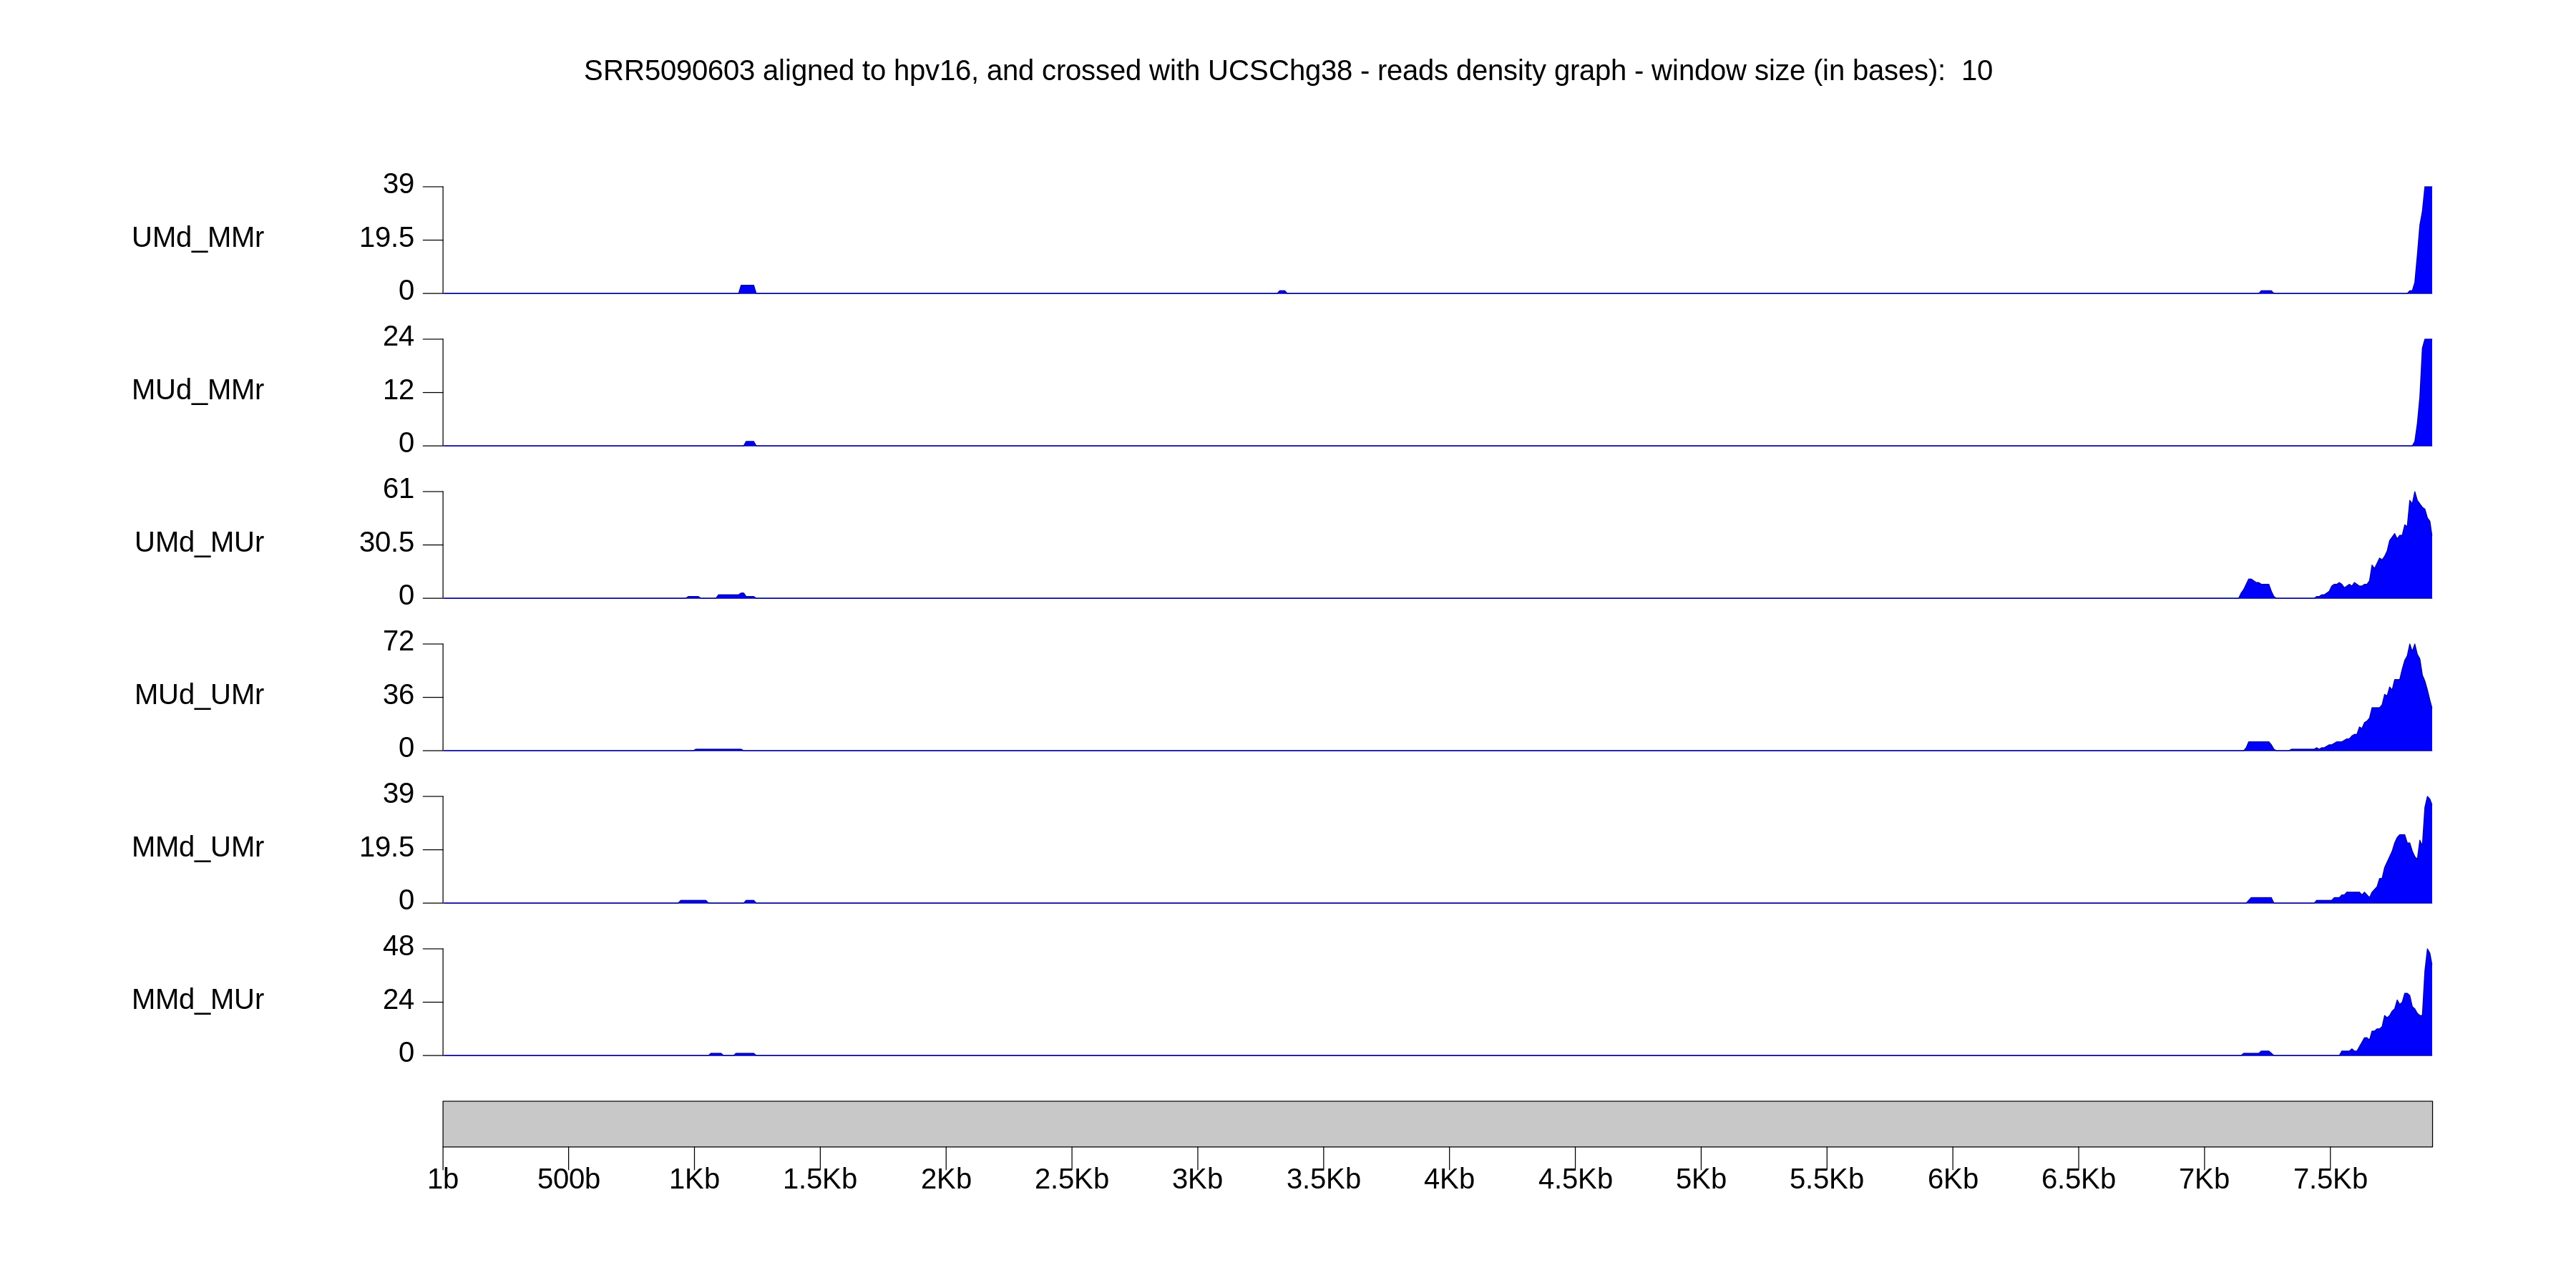

In [13]:
# Plot of all relevant crossings over the potential donor reference genome
options(repr.plot.width=30, repr.plot.height=15)
title_prepend <- paste(srr_name, ' aligned to ', donor_name, ', and crossed with ', recipient_name, sep = "")

create_viz_donor(ref_genome = donor_ref_genome, 
                 granges = donor_granges,  
                 granges_labels = donor_granges_crossings,
                 title_prepend = title_prepend)

In [14]:
# Aggregated view of all overlapping crossings for the potential donor
summary_table_donor(granges = donor_granges, 
                    granges_labels = donor_granges_crossings, 
                    min_num_crossings = 1, 
                    min_num_reads = 3)

chr,start,stop,num_crossings,unique_crossings,num_reads
NC_001526.4,944,1239,6,"UMd_MMr, MUd_MMr, UMd_MUr, MUd_UMr, MMd_UMr, MMd_MUr",14
NC_001526.4,7148,7272,5,"UMd_MMr, UMd_MUr, MUd_UMr, MMd_UMr, MMd_MUr",22
NC_001526.4,7449,7906,6,"UMd_MMr, MUd_MMr, UMd_MUr, MUd_UMr, MMd_UMr, MMd_MUr",463


## Recipient Analysis

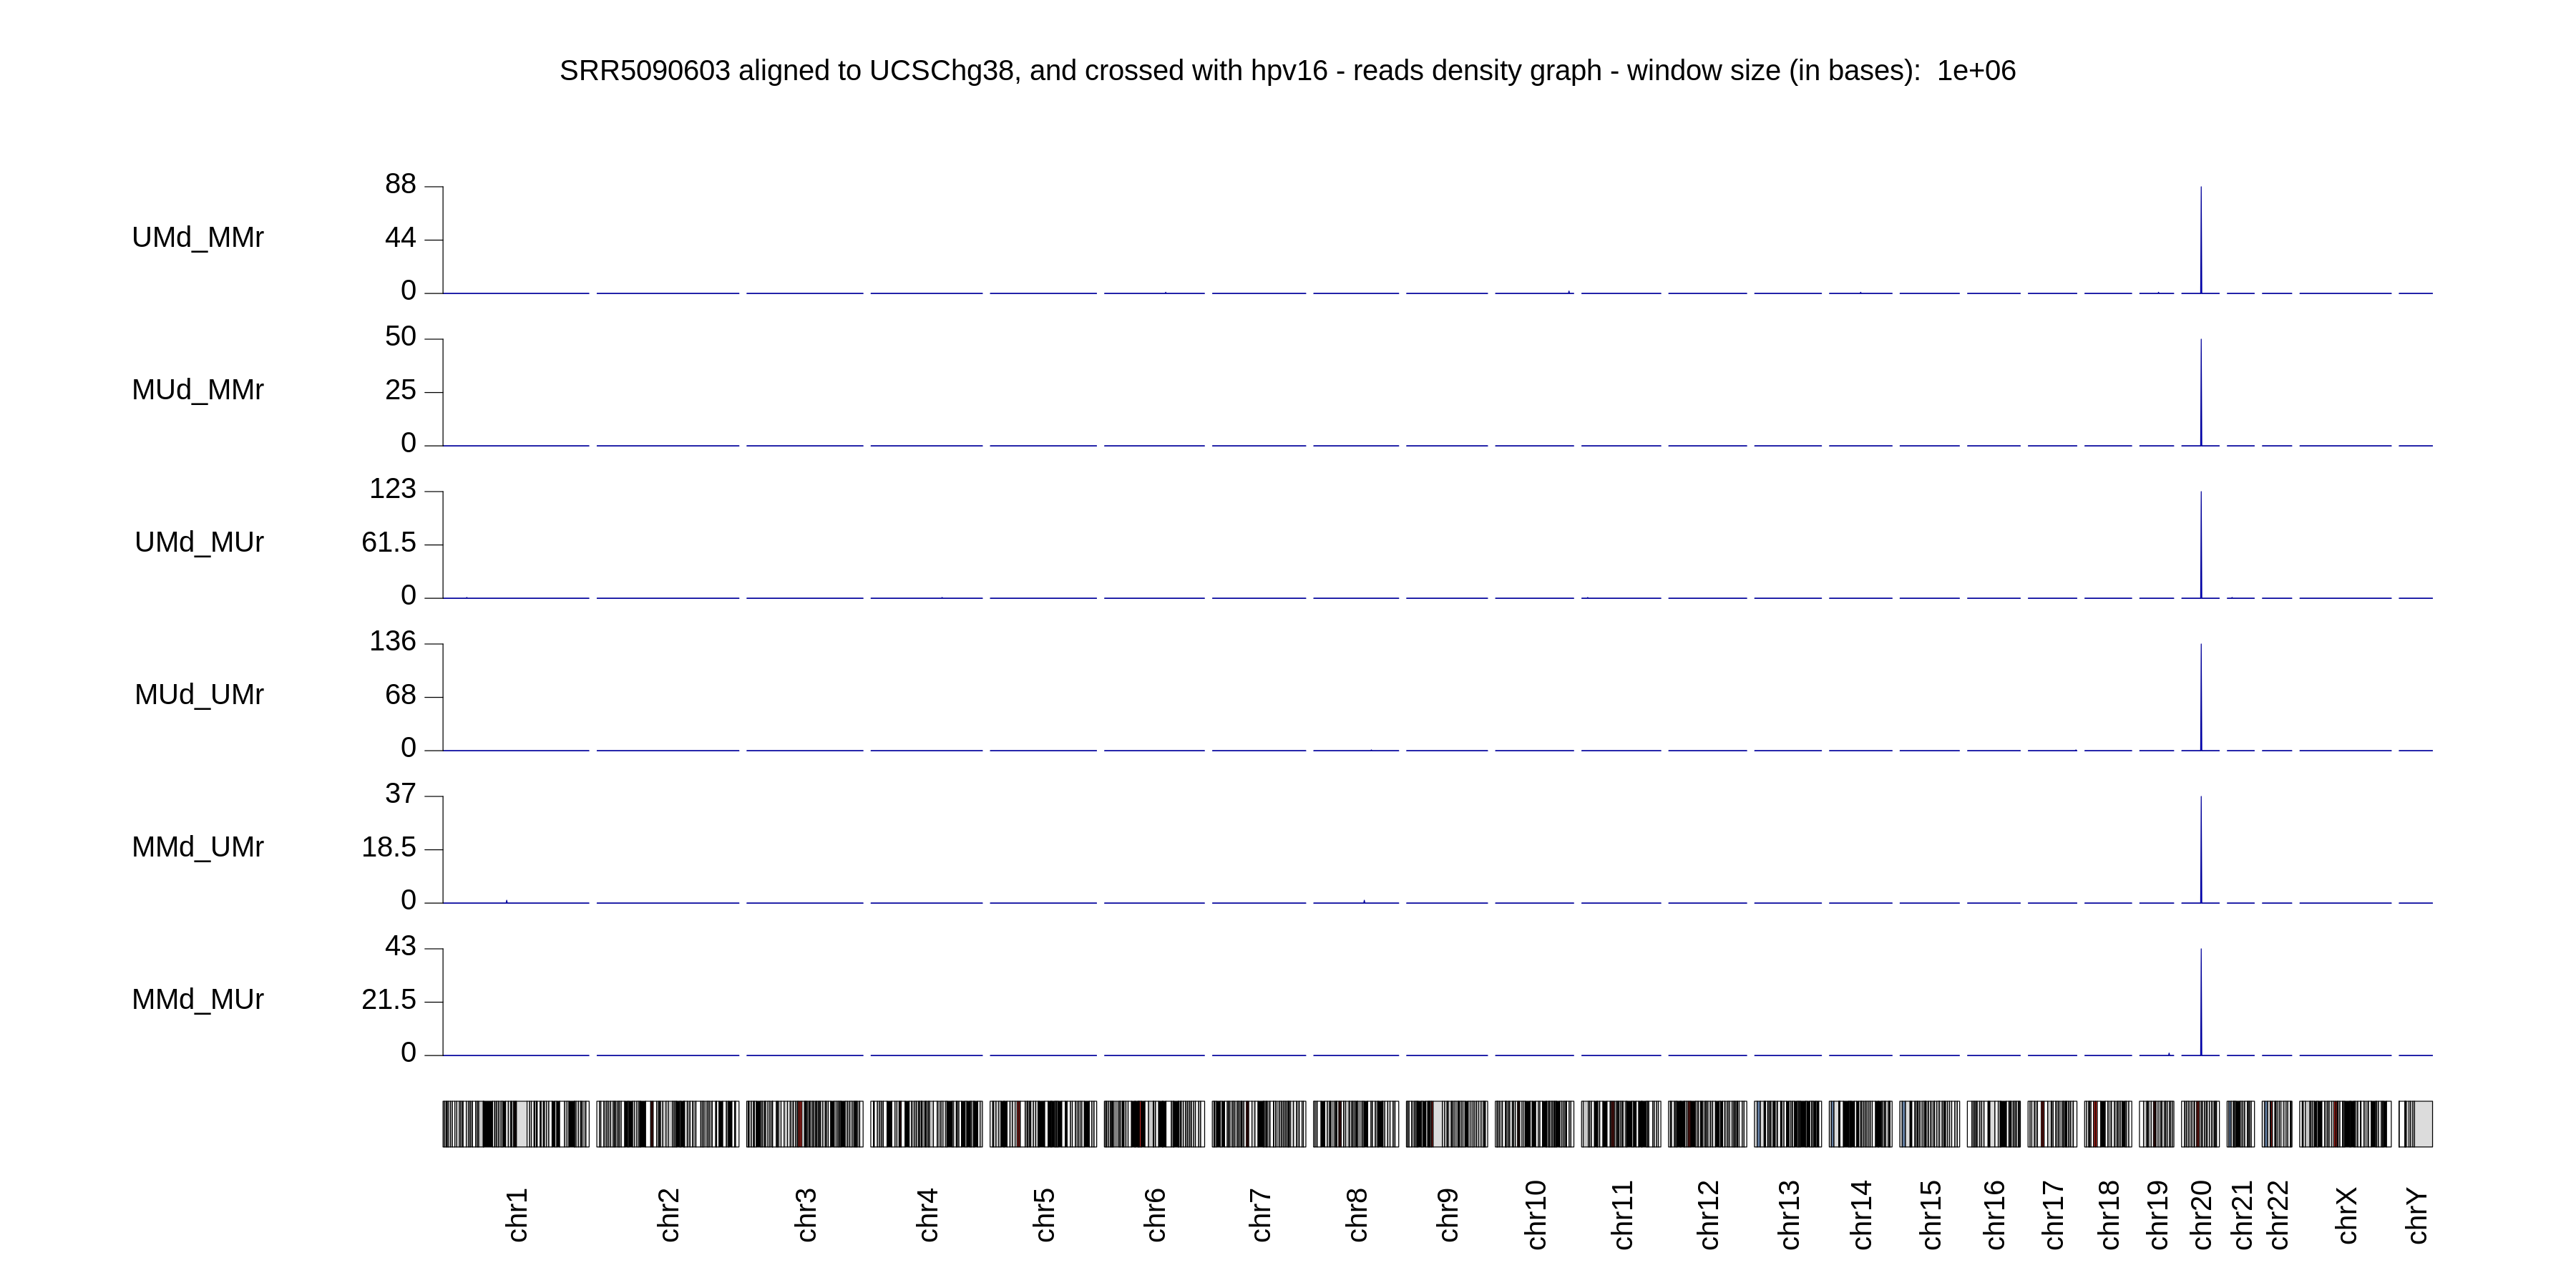

In [15]:
# Plot of all relevant crossings over the potential recipient reference genome
options(repr.plot.width=30, repr.plot.height=15)
title_prepend <- paste(srr_name, ' aligned to ', recipient_name, ', and crossed with ', donor_name, sep = "")

create_viz_recipient(ref_genome="hg38", 
                     granges = recip_granges, 
                     granges_labels = recip_granges_crossings, 
                     title_prepend = title_prepend)

In [16]:
# Aggregated view of all overlapping crossings for the potential recipient
crossings_table_recipient <- summary_table_recipient(granges = recip_granges,
                                                     granges_labels = recip_granges_crossings, 
                                                     min_num_crossings = 2, 
                                                     min_num_reads = 7, 
                                                     src = src, 
                                                     Hsapiens = Hsapiens)

id,chr,start,stop,num_crossings,unique_crossings,num_reads,gene_name,sequence
1,chr20,33707709,33707974,4,"UMd_MMr, MUd_MMr, UMd_MUr, MUd_UMr",29,PXMP4,ATTGGAGGGACGGCTCTTGTTATAGACGAGGAAGTCTGAGATGTCGTGCCATACATTGCTGTCCTCATAGAGGTAGGTCATGGAGGACTGCAGCGAGGGCTGCAGGGTGGATCGGTGATACTCAAAGAGCCACAGCACCAGCCCCCACACCACCGCAGTGAGCAGCGGGAACGGGTCCCACCTGGGTTCAGGGATGTAGCCCTTCTCTACAGCCAGGCGGCTCAGGGCAAACAGGACGCGTGACAACAGGTACATGTTGATCTGCA
2,chr20,33710553,33710757,3,"UMd_MMr, UMd_MUr, MUd_UMr",51,PXMP4,ACCTGGCTGTTGATGTTATTGTTTTCTCCAAACACCAGGATACCCCCGAGGAAGGCCGCCAGGAATGCGTGTGCTGGGTAGGTCTTGCCTTGTATGTAGGACTGCAGGGCACGGAGACCCTTGTAGGTGAACACAAACCGTGCCAGGTTCCAGGAGTGGATATATGTGGCCTGCAGTATGGCCCACAGCTTCTCCTGGAGGCTGC
3,chr20,33714672,33714742,6,"UMd_MMr, MUd_MMr, UMd_MUr, MUd_UMr, MMd_UMr, MMd_MUr",116,PXMP4,ACCTGCCATTCCGGAAGAGAAAGGTCATGACCAGCGCGTGAGGGGCCCGGATTTTGGCTCCATAGCTGTAG
4,chr20,33728689,33729163,6,"UMd_MMr, MUd_MMr, UMd_MUr, MUd_UMr, MMd_UMr, MMd_MUr",205,,GTCACTTTTGTCTCCACAGAGACAACTTGTCAGGAACAGTGGCTAGCAGGGTTCCCCAAGGGGAGAGGAACTTTGAAAAAACAATTTTAAAAAATTGTAGTTCACAGGTCTCAAACTCCTGGGCTCATGCAGTCCTCCTGCCTTGGCCTCTCAAAGTGCTAGGCTTAGAGCAGTGCGCCACCATGCCCAGCTGCAAACAAATAATTTTTAATTGTAGGAGTTATATAGTGAATACAAGAAAATGAAAATTATGATATTTGTTATTTATTTAGCTGAGGCTAAAATAGGTATTTTAGTAAAACCAATGAGAACATTTAGAGTCCAATCCATGGTTGTCCCGTTGTATGACGATGTGGCCATGATCATGGGAGAGATTCATGATTGATGGTGACAAAGATTCTTTGCTTGCTGTAACTGCTTGGTCAGACTTTGGAATCTTCTGCTAGGCCCACCTGTGCACTTCTTTGTAAAATCT
5,chr20,33738723,33738907,5,"UMd_MMr, UMd_MUr, MUd_UMr, MMd_UMr, MMd_MUr",20,ZNF341,CATTGAAGGGAGGAGAGATGGAAACATGAATTTGCAGGAGGGCACTCTGGAGAGACTGATCGTGTGTAGCTGTGGATGGTTCCCAGGCACAGTGTGGTGAGAGTTGGTGGAGAGTGGCTTCTGAGGAGCAGGAGGAGATGGAGGGGAGGGCTGCGCTGGCAGCGTCAGGAGGGACACAGCCTGCA
6,chr20,33739972,33740250,5,"UMd_MMr, MUd_MMr, UMd_MUr, MUd_UMr, MMd_MUr",15,ZNF341,CTCCTGCCTCAGTCTCCCAAGTAGTTGGGATTACAGGCACACACCACCACGCCCAGCTAATTTTGTATTTTTAGTAGAGACAGGGTCTCACCATGTTGGCCAGGATGGTCTCGAACTCCTGACCTCAGGTGCTCTGCCCGCCTTGGCCACCCAGAGTGTTGGGATTACAGGCGTGAGCCACTGCGCCTGGCTCCATCCAGCTTTTTATCCTACGATCCTAAGGTTGTCCTTATGATCCAGGATGGTGGATTGAGTTGCTACCACCATATTCTTATTCTG
7,chr20,33740980,33741089,4,"UMd_MMr, MUd_MMr, UMd_MUr, MUd_UMr",8,ZNF341,GTGTCAATGCGCCCCCTGCTATCCAGCCATTGGGTGAGTATCTGCTCAGGTTCACCGGTGGGAGAGTGAATGGCTCCCCGCGAAGAGTAGGTGGAGCTTGTGCTGGGCTG
8,chr20,33744849,33745056,6,"UMd_MMr, MUd_MMr, UMd_MUr, MUd_UMr, MMd_UMr, MMd_MUr",15,ZNF341,CGCAAAGTGCTGGGATTACAGGCATGAGCCACTGTGCCTGGCCACCTGTGTGGCTTCGAAAACTCCCAGGAAGCACATAGTTGATGGCTGACACCTGCATGTCAAGTCGCAGCATGCCCCCCAGATTGCTGCTTGTGGTCAGCTGCAGTTCTCCTGTCTCATACTGTGATGCCCCTTGACATAGTCTTGCTTTTTTTTCATTACTTTA
9,chr20,33680324,33680419,3,"UMd_MUr, MUd_UMr, MMd_UMr",7,E2F1,ACCTTTTCCTGGATGGCGGCCTCTGCCCCGAGCTGGCCCACTGCTCTCGGCCAGGTACTGATGGTCAGTTTCCAGGTCCAGCCTCCGCTTCACCTG


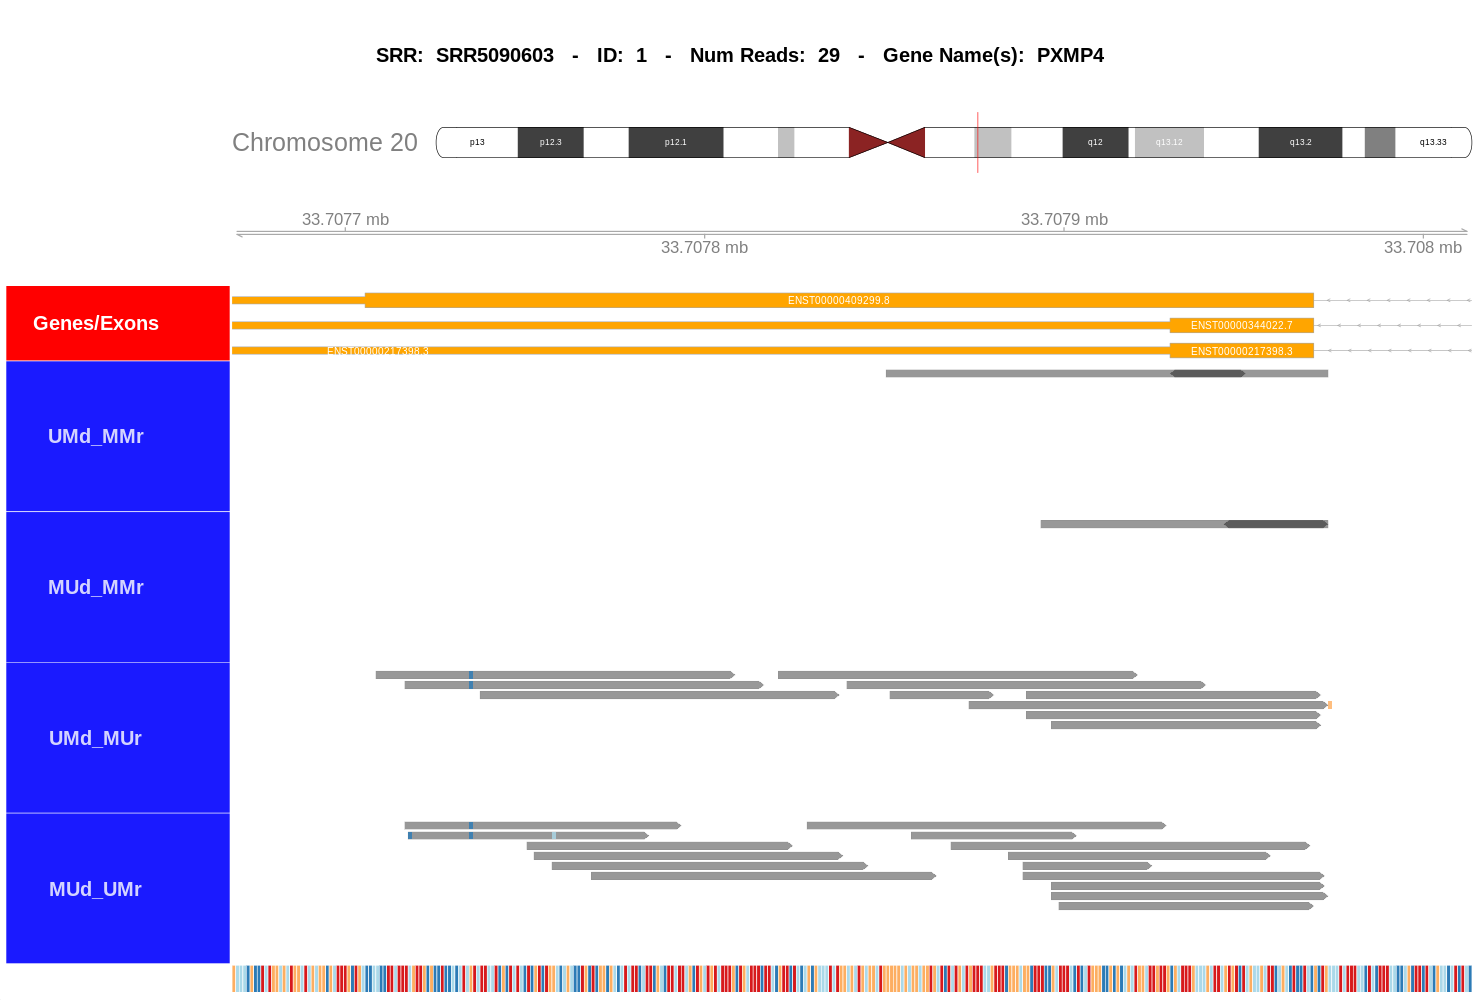

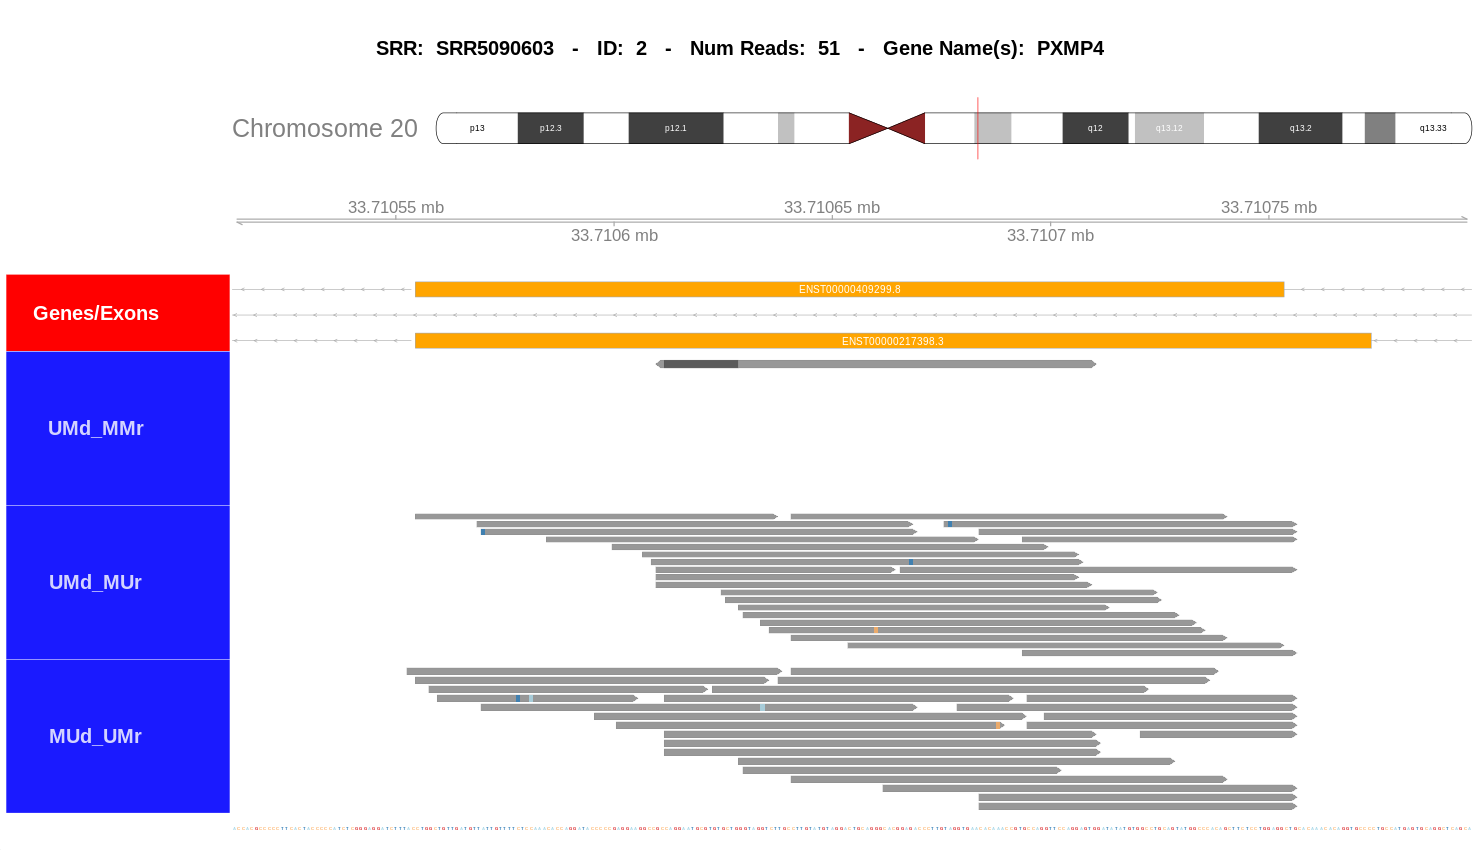

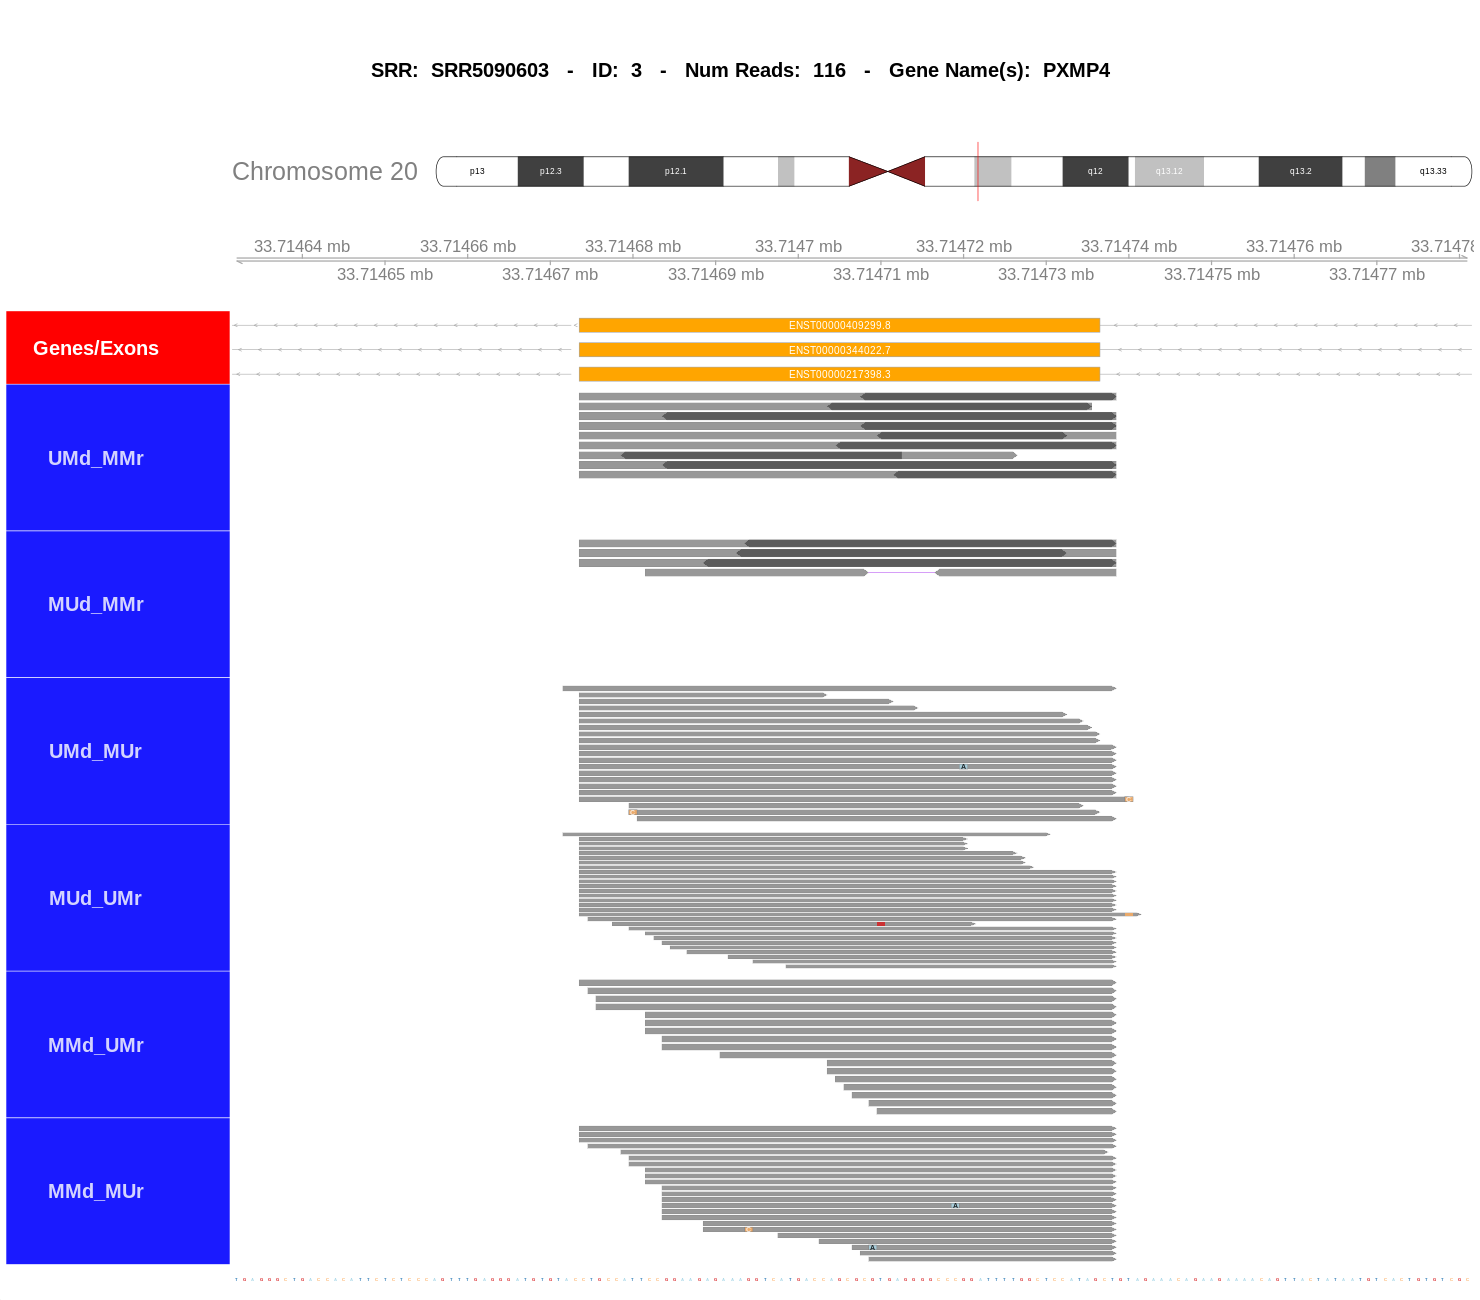

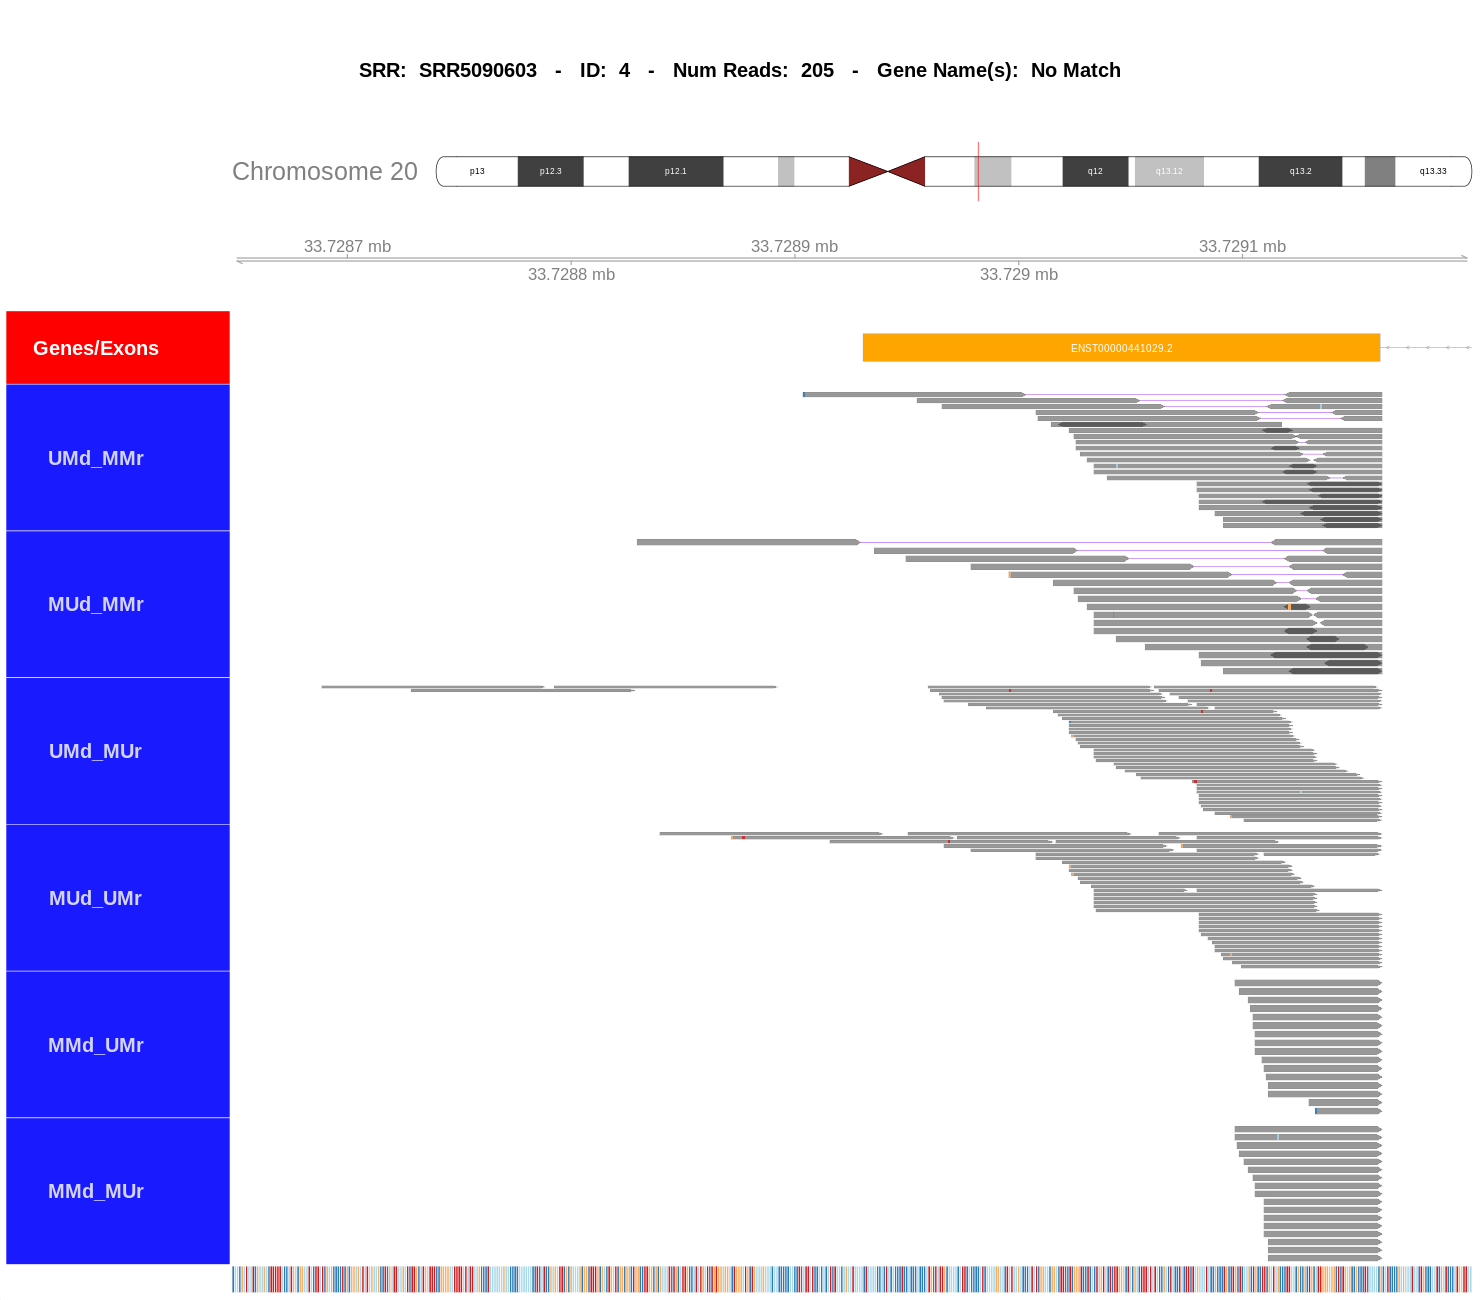

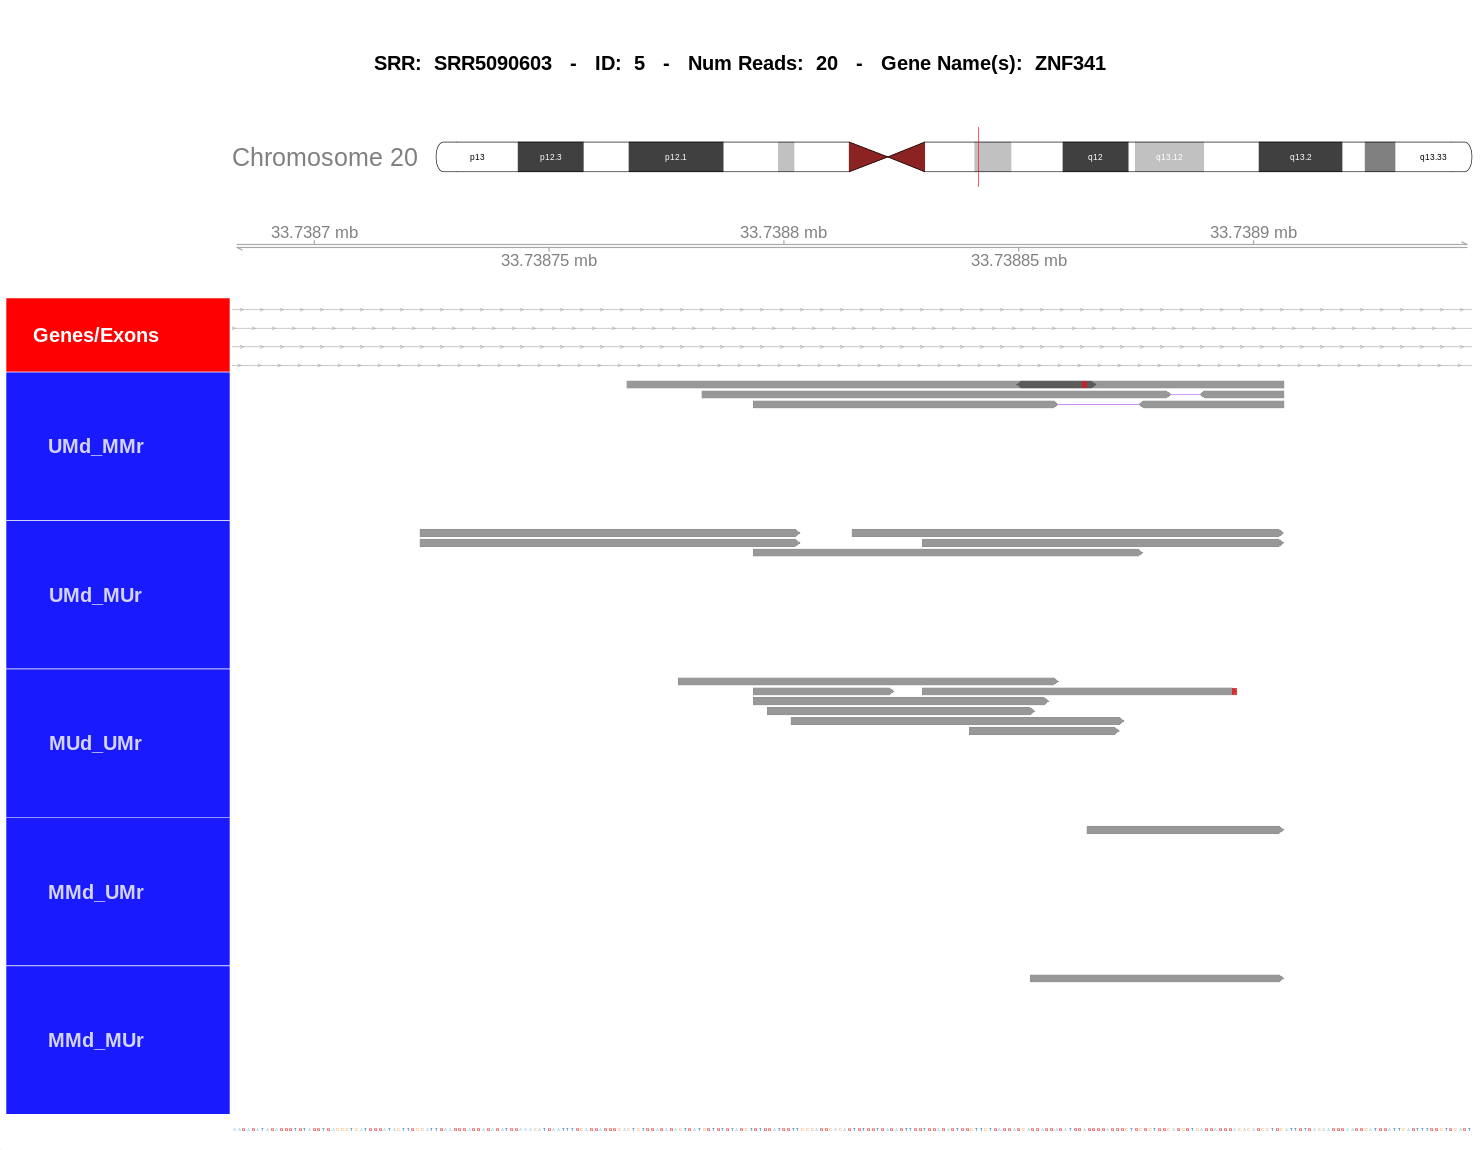

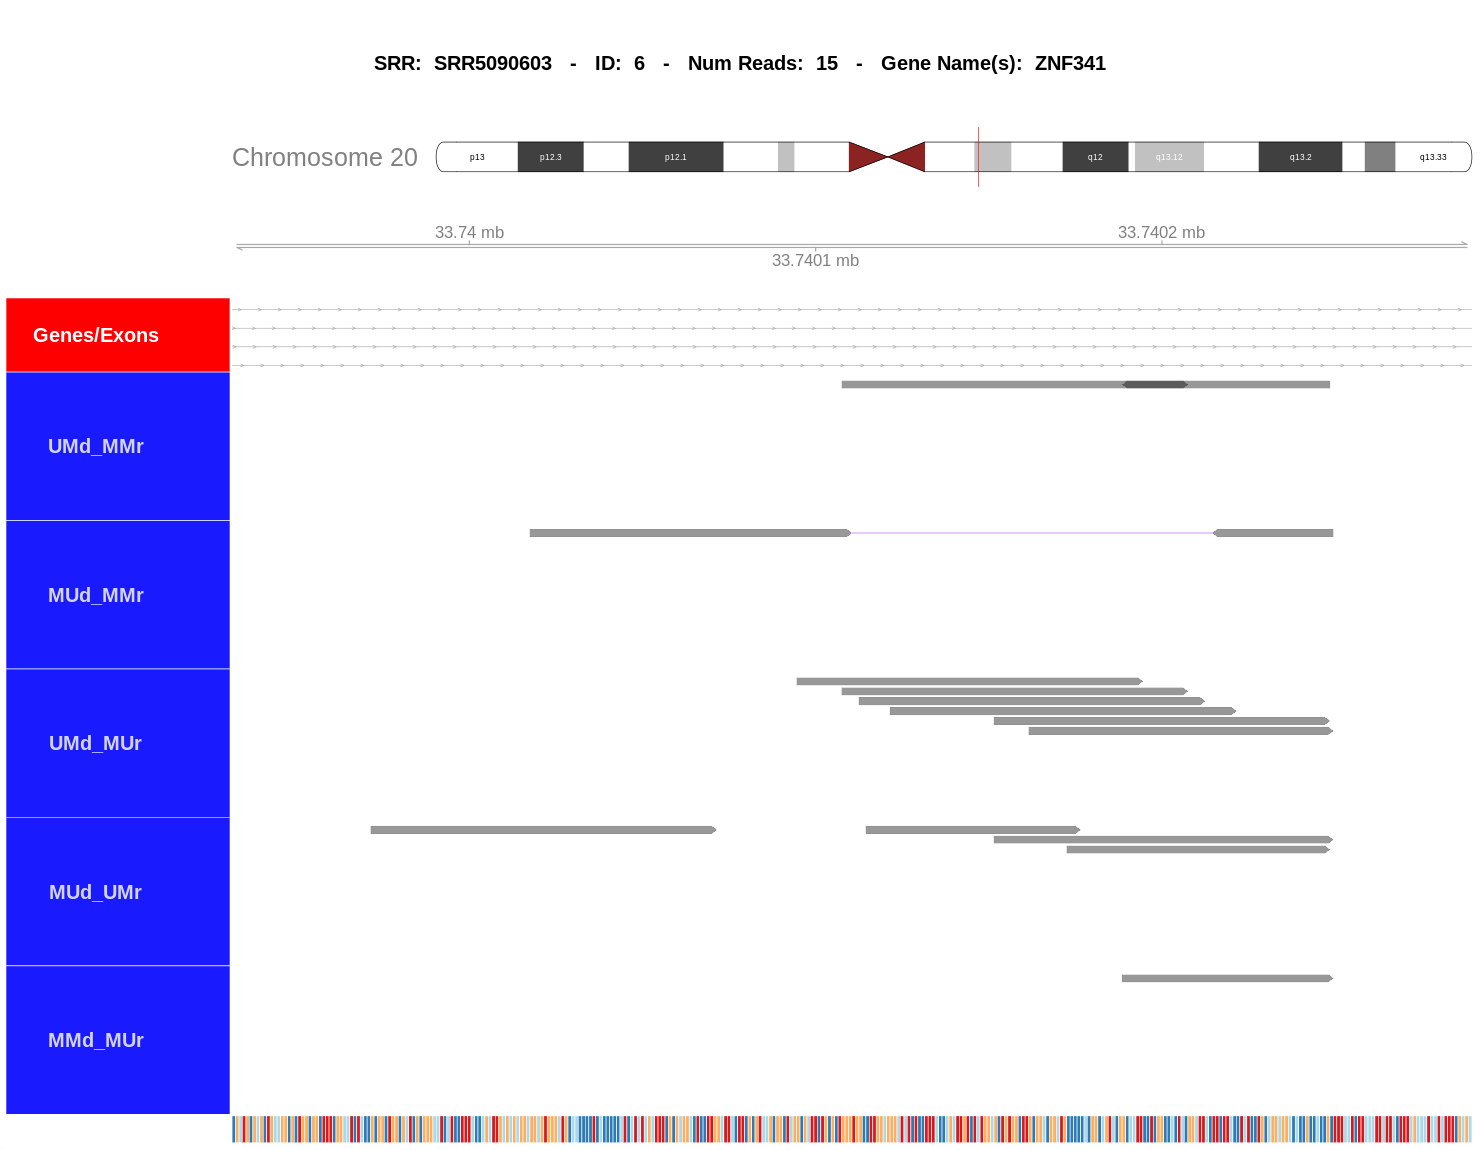

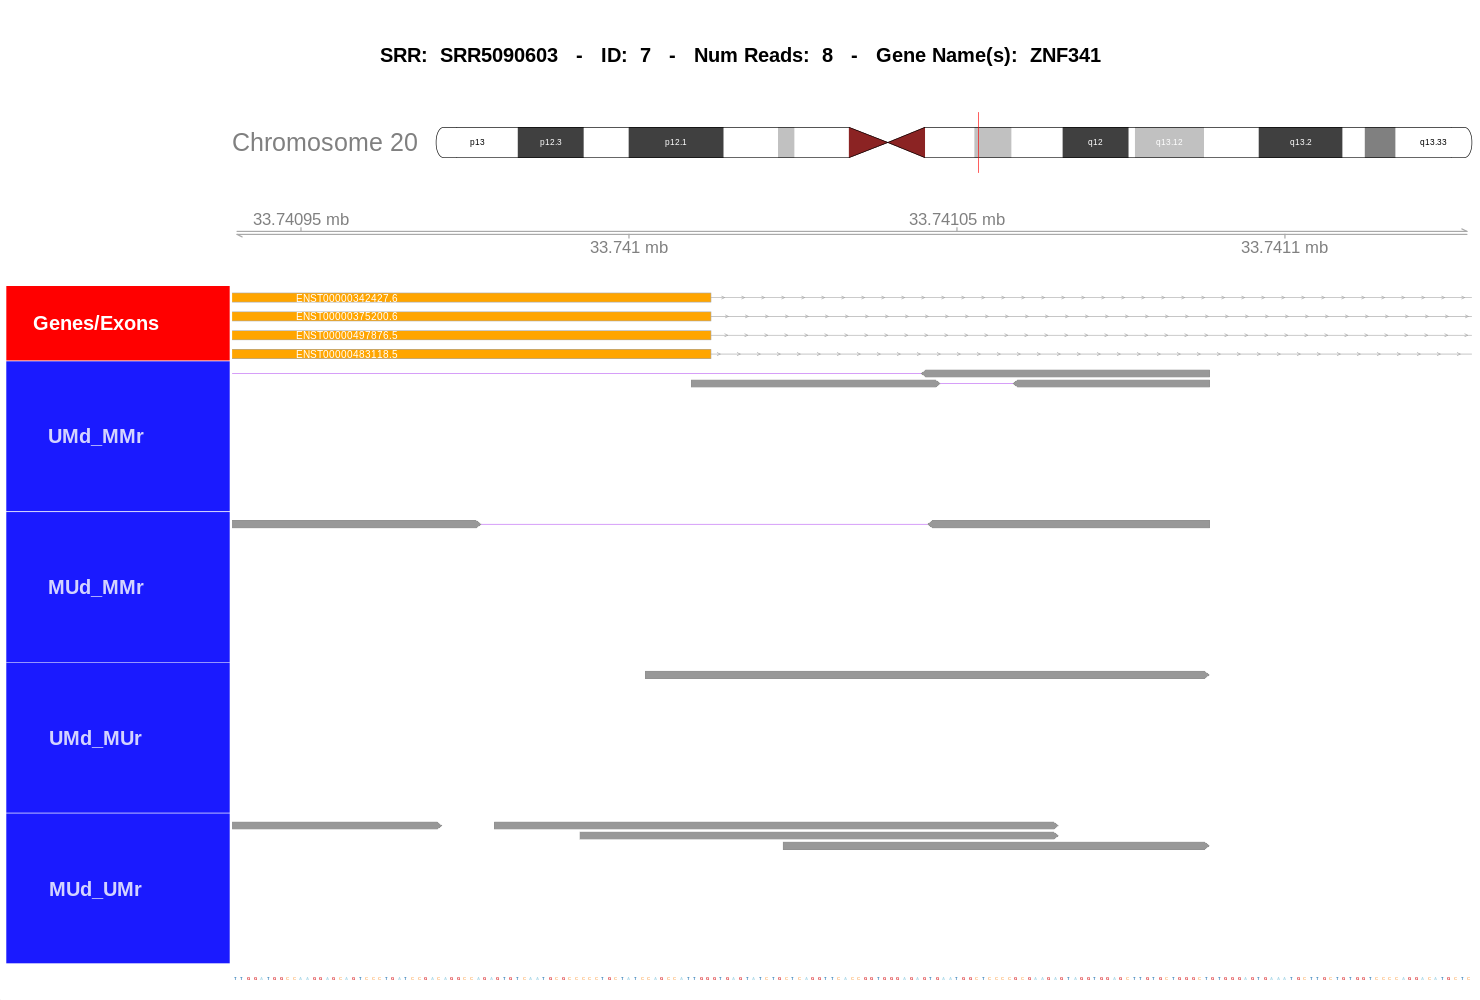

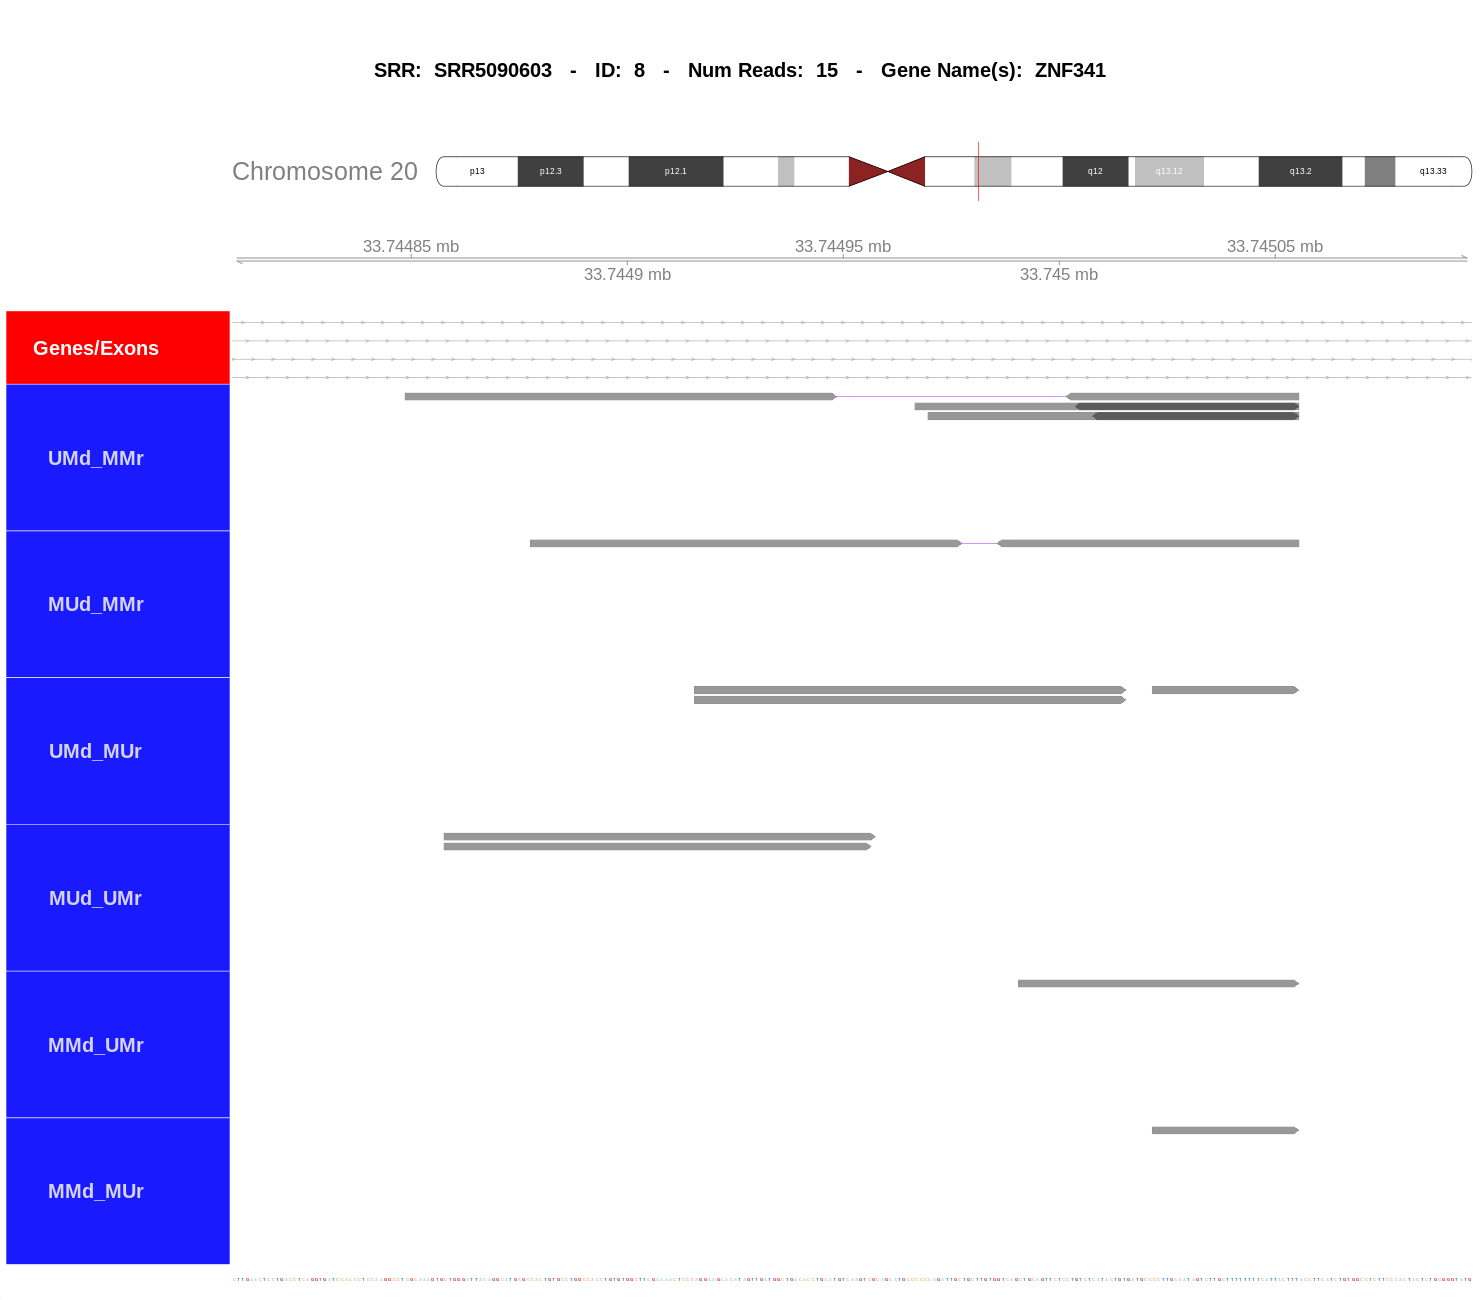

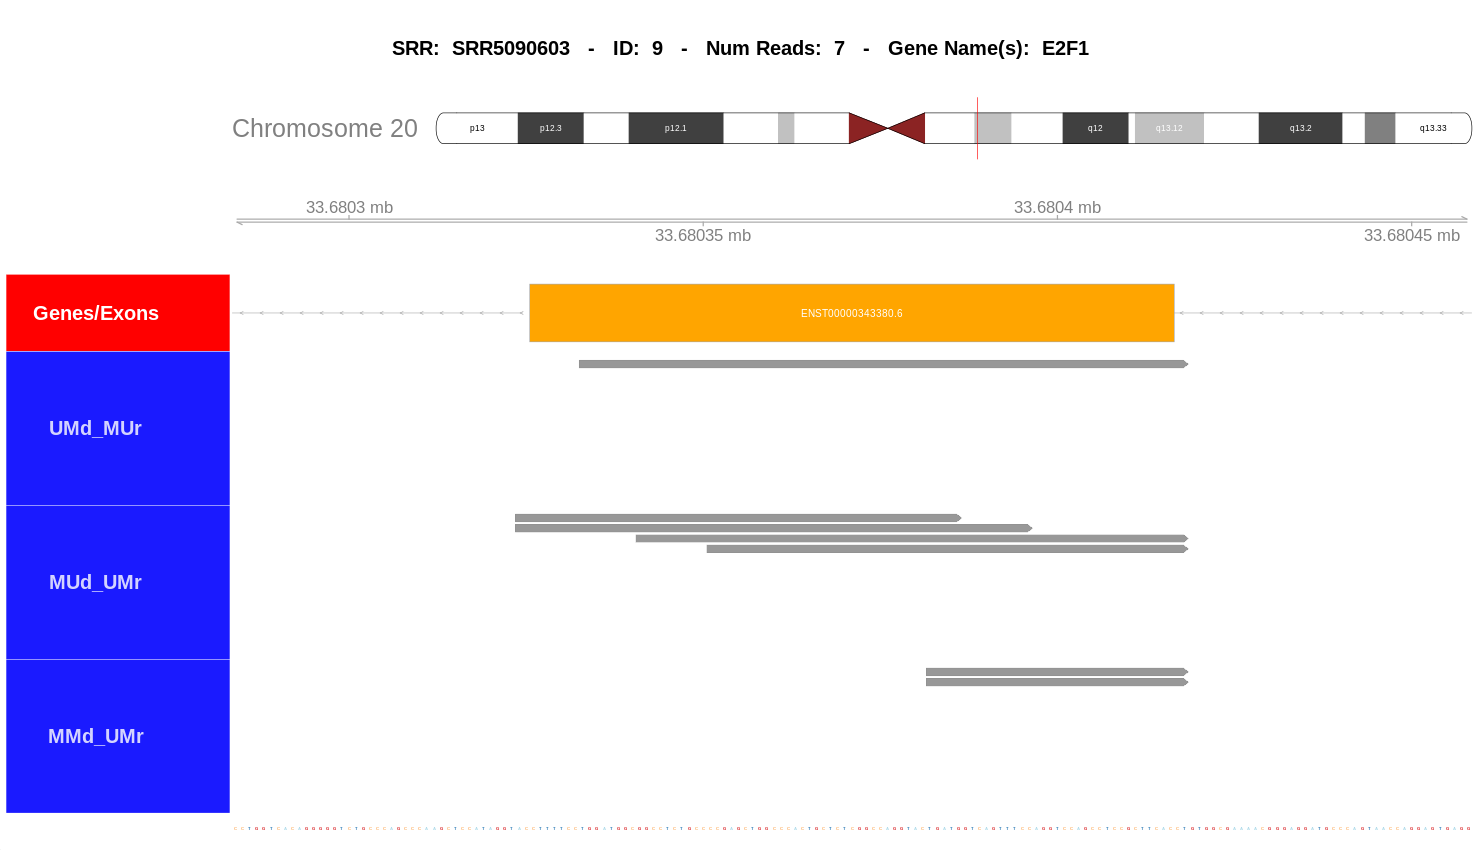

In [17]:
# Plot all the overlapping reads for all 'ids'

# delete all existing plots in the "plots" folder
was_deleted <- do.call(file.remove, list(list.files("./plots", full.names = TRUE)))

# extract id list
ids <- as.list(crossings_table_recipient[,"id"]$id)

# create a visualization for all 'id's
for (id in ids) {
    # calculate height
    crossings_number <- length(as.list(strsplit(crossings_table_recipient[id,]$unique_crossings[[1]], ",")))
    height <- 400 + 150 * crossings_number
    
    # open image writer
    png(paste("./plots/plots_" , id, ".png", sep = ""), width = 1480, height = height, res = 60)
        # plot graph
        plot_reads_region(srr = srr_name,
                  id = as.integer(id), 
                  crossings_table_recipient = crossings_table_recipient, 
                  recip_bams = recip_bams,
                  extend_left = 20, 
                  extend_right = 20, 
                  ref_genome = recipient_ref_genome)
    dev.off()
    # display plot as image
    display_png(file=paste("./plots/plots_", id,".png", sep=""))      
}